In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP Dataset/train.csv')

In [ ]:
labels = df[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

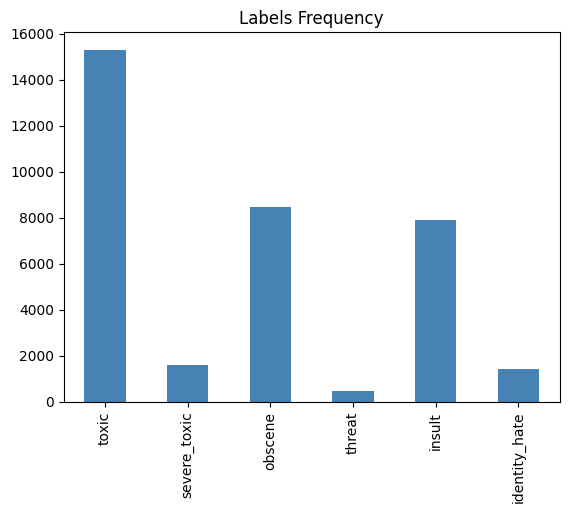

In [ ]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
max_features = 200000
vectorize = TextVectorization(max_tokens=max_features, output_sequence_length=2000,output_mode='int')
vectorize.adapt(X.values)

In [ ]:
vectorized_text = vectorize(X.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))

In [ ]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size)

Models building

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 909s 129ms/step - loss: 0.0623 - val_loss: 0.0463
Epoch 2/5
6981/6981 [==============================] - 799s 114ms/step - loss: 0.0455 - val_loss: 0.0400
Epoch 3/5
6981/6981 [==============================] - 805s 115ms/step - loss: 0.0409 - val_loss: 0.0355
Epoch 4/5
6981/6981 [==============================] - 796s 114ms/step - loss: 0.0356 - val_loss: 0.0319
Epoch 5/5
6981/6981 [==============================] - 793s 114ms/step - loss: 0.0325 - val_loss: 0.0299


In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 766ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0]])

In [ ]:
model.save('toxicity.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/NLP Dataset/toxicity.h5')

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 54ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8680400848388672, Recall:0.8359249234199524, Accuracy:0.48048049211502075


In [ ]:
from wordcloud import WordCloud

In [ ]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = df[df[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=400, height=400,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()


Choose a class to visualize the most common words contributing to the class:toxic


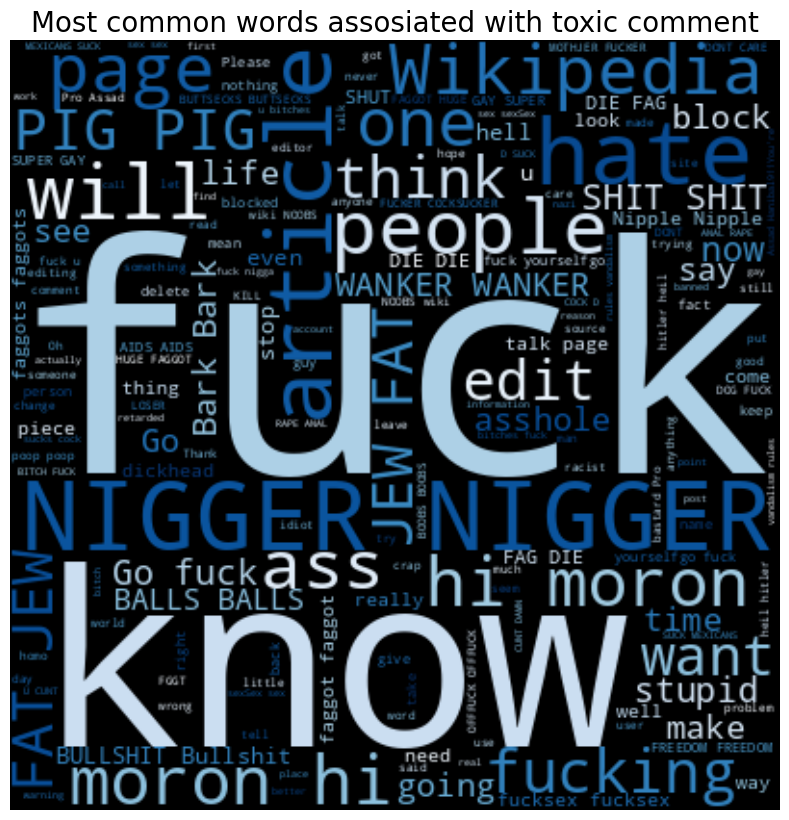

In [ ]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

Anvil server




In [ ]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=1850c1067845dd311ae9d53479a8194bca45a89d514b665ba1ca305d4bca96bd
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
import anvil.server

In [ ]:
anvil.server.connect("server_7CPC3BHF4EVENZEWUCKIOR72-Y6PVGJQ3L5XVV6XZ")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Published" as SERVER


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/NLP Dataset/toxicity.h5')

In [ ]:
@anvil.server.callable
def predict(comment_text):
    vectorized_comment = vectorize([comment_text])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text